In [1]:
import netCDF4
import matplotlib.pyplot as plt
import numpy as np

import bokeh.io
bokeh.io.output_notebook()

from bokeh.layouts import gridplot
from bokeh.plotting import figure
%matplotlib inline

Loading BokehJS ...

In [2]:
# this notebook shows how to generate grid enclosures for the case where you only have cell centres for a curvilinear grid


ds = netCDF4.Dataset('/Users/baart_f/data/matroos/201606211200.nc')


In [3]:
# take a subset
s = np.s_[200:300, 900:1000]
# s = np.s_[:, :]
lat_orig = ds.variables['lat'][s]
lon_orig = ds.variables['lon'][s]

# make copies so we can edit in place
# we edit lat, lon by adding ghost cells
lat = lat_orig.copy()
lon = lon_orig.copy()


In [4]:
# We create ghost cells by computing boolean differences from different directions

# cells are on an edge if there is a change in mask difference from a direction
right = np.logical_and(lat[:,:-1].mask, np.diff(lat.mask, axis=1))
left = np.logical_and(lat[:,1:].mask, np.diff(lat.mask, axis=1))
left_right = np.logical_and(left, right)
top = np.logical_and(lat[1:,:].mask, np.diff(lat.mask, axis=0))
bottom = np.logical_and(lat[:-1,:].mask, np.diff(lat.mask, axis=0))
top_bottom = np.logical_and(top, bottom)


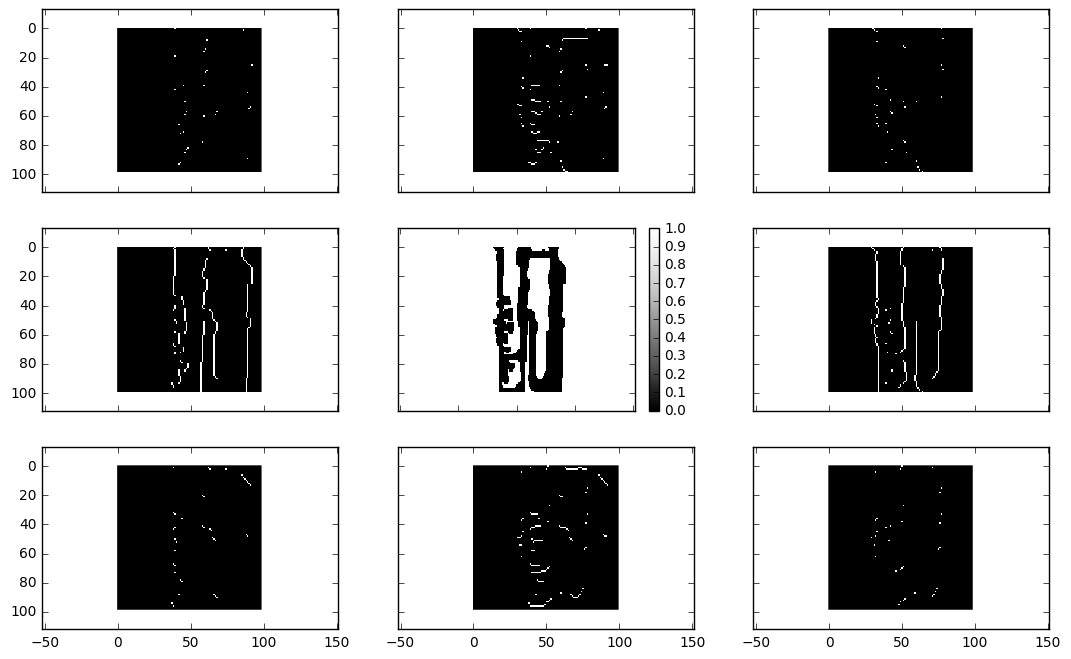

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(13, 8), sharex=True, sharey=True)

                       
# change from right
axes[1, 2].imshow(right, cmap='Greys_r', interpolation='none')
# changes from left
axes[1, 0].imshow(left, cmap='Greys_r', interpolation='none')

# changes from top
axes[0, 1].imshow(top, cmap='Greys_r', interpolation='none')
# changes from bottom
axes[2, 1].imshow(bottom, cmap='Greys_r', interpolation='none')

# changes from top left
axes[0, 0].imshow(np.logical_and(top[:,:-1], left[:-1,:]), cmap='Greys_r', interpolation='none')
# changes from top right
axes[0, 2].imshow(np.logical_and(top[:,:-1], right[1:,:]), cmap='Greys_r', interpolation='none')
# changes from bottom left
axes[2, 0].imshow(np.logical_and(bottom[:,1:], left[:-1,:]), cmap='Greys_r', interpolation='none')
# changes from bottom right
axes[2, 2].imshow(np.logical_and(bottom[:,1:], right[1:,:]), cmap='Greys_r', interpolation='none')


# changes left and right
im = axes[1, 1].imshow(lat[:,:].mask, cmap='Greys_r', interpolation='none')
plt.colorbar(im, ax=axes[1,1])

# axes[1, 2].imshow(np.logical_and(lat[1:,1:].mask, np.diff(lat.mask, axis=0)), cmap='Greys_r', interpolation='none')
# np.diff(lat, axis=1)


In [6]:
lat = lat_orig.copy()
lon = lon_orig.copy()

# fill from bottom
i, j = np.where(bottom)
not_edge = (i + 2) < lat.shape[0]
i = i[not_edge]
j = j[not_edge]
lat[i, j] = lat[i+1,j] + (lat[i+1, j] - lat[i+2, j]) 
lon[i, j] = lon[i+1,j] + (lon[i+1, j] - lon[i+2, j]) 


# fill from top
i, j = np.where(top)
not_edge = np.logical_and(i > 0, (i + 1) < lat.shape[0])
i = i[not_edge]
j = j[not_edge]
lat[i+1, j] = lat[i,j] + (lat[i, j] - lat[i-1, j]) 
lon[i+1, j] = lon[i,j] + (lon[i, j] - lon[i-1, j]) 


# fill from left
i, j = np.where(left)
not_edge = np.logical_and(j > 0, (j + 1) < lat.shape[1])
i = i[not_edge]
j = j[not_edge]
lat[i, j+1] = lat[i,j] + (lat[i, j] - lat[i, j-1]) 
lon[i, j+1] = lon[i,j] + (lon[i, j] - lon[i, j-1]) 

# fill from right
i, j = np.where(right)
not_edge = (j + 2) < lat.shape[1]
i = i[not_edge]
j = j[not_edge]
lat[i, j] = lat[i,j+1] + (lat[i, j+1] - lat[i, j+2]) 
lon[i, j] = lon[i,j+1] + (lon[i, j+1] - lon[i, j+2]) 



In [7]:
lat_bounds = np.ma.zeros(lat.shape + (5,))
lat_bounds.mask = True
lon_bounds = np.ma.zeros(lat.shape + (5,))
lon_bounds.mask = True


# ll
lat_bounds[1:-1, 1:-1, 0] = (lat[1:-1, 1:-1] + lat[:-2, 1:-1] + lat[:-2, :-2] + lat[1:-1, :-2])/4.0
lon_bounds[1:-1, 1:-1, 0] = (lon[1:-1, 1:-1] + lon[:-2, 1:-1] + lon[:-2, :-2] + lon[1:-1, :-2])/4.0

# lr
lat_bounds[1:-1, 1:-1, 1] = (lat[1:-1, 1:-1] + lat[:-2, 1:-1] + lat[:-2, 2:] + lat[1:-1, 2:])/4.0
lon_bounds[1:-1, 1:-1, 1] = (lon[1:-1, 1:-1] + lon[:-2, 1:-1] + lon[:-2, 2:] + lon[1:-1, 2:])/4.0

# ur
lat_bounds[1:-1, 1:-1, 2] = (lat[1:-1, 1:-1] + lat[2:, 1:-1] + lat[2:, 2:] + lat[1:-1, 2:])/4.0
lon_bounds[1:-1, 1:-1, 2] = (lon[1:-1, 1:-1] + lon[2:, 1:-1] + lon[2:, 2:] + lon[1:-1, 2:])/4.0

# ul
lat_bounds[1:-1, 1:-1, 3] = (lat[1:-1, 1:-1] + lat[2:, 1:-1] + lat[2:, :-2] + lat[1:-1, :-2])/4.0
lon_bounds[1:-1, 1:-1, 3] = (lon[1:-1, 1:-1] + lon[2:, 1:-1] + lon[2:, :-2] + lon[1:-1, :-2])/4.0

lat_bounds[1:-1, 1:-1, 4] = lat_bounds[1:-1, 1:-1, 0]  
lon_bounds[1:-1, 1:-1, 4] = lon_bounds[1:-1, 1:-1, 0]  

    

In [8]:
figure = bokeh.plotting.figure(webgl=False, active_scroll="wheel_zoom")
c = figure.circle(lon_orig.flatten(), lat_orig.flatten())
c = figure.circle(lon[lat_orig.mask].flatten(), lat[lat_orig.mask].flatten(), line_color='red', line_width=1, fill_alpha=0, radius=0.0005*3 )

c = figure.circle(lon_bounds[...,0].flatten(), lat_bounds[...,0].flatten(), line_color='black', line_width=1, fill_alpha=0, radius=0.0004*3)
c = figure.circle(lon_bounds[0,1:-1,0].flatten(), lat_bounds[0,1:-1,0].flatten(), line_color='red', line_width=1, fill_alpha=0, radius=0.0004*3)
c = figure.circle(lon_bounds[...,1].flatten(), lat_bounds[...,1].flatten(), line_color='black', line_width=1, fill_alpha=0, radius=0.0003*3)
c = figure.circle(lon_bounds[0,1:-1,1].flatten(), lat_bounds[0,1:-1,1].flatten(), line_color='red', line_width=1, fill_alpha=0, radius=0.0003*3)
c = figure.circle(lon_bounds[...,2].flatten(), lat_bounds[...,2].flatten(), line_color='black', line_width=1, fill_alpha=0, radius=0.0002*3)
c = figure.circle(lon_bounds[...,3].flatten(), lat_bounds[...,3].flatten(), line_color='black', line_width=1, fill_alpha=0, radius=0.0001*3)

figure.line(lon_bounds[0:-1, 1:-1,:].flatten(), lat_bounds[0:-1,1:-1,:].flatten())
bokeh.io.show(figure)